
A good DTD must be a leverage ratio adjusted for trend and volatility of the firm's asset value.

Computing DTD:
        
        parameters --> market value of firm's assets; parameters governing movement of assets (trend and volatility)
        
GENERAL INFO:         

        asset value of firm follows geometric Brownian motion. AND asset value as function of B.S.
        
        MERTON MODEL DTD equation --> means log(leverage ratio) scaled by the volatility
        Looking for sutiable estimates of the expected return and volatility
        
        EQUATION 5 to reduce sampling errors with DTD calculations. mean = sigma^2/2
        PRODUCES A MORE STABLE DTD estimate.
        
       
ESTIMATING ASSET VALUE.................................       
        
        PROBLEM --> Financial firms have large portion of liabilities and asset volatility inflated causing a distortion in the Standard KMV DTD modeling.
        
        
A) MARKET VALUE PROXY METHOD --> adding market value of equity and debt = firm value

    ADDING MARKET CAPITALIZATION to the book value of liabilities. Estimating mean and volatility straightforward.
    1) Get daily asset values by summing daily market cap with quarterly book updates.
    2) Obtain daily log of asset returns and compute sample mean and stdev.

LIKELY will produce an upward biased estimate of asset value related to how volatile the asset value is. REASON: value of discounted debt set to its par value --> INFLATES market value (discount portion) increases with the firm's volatility. [Firm's equity would always be in the money] at time of assesing credit risk --> UPWARD biased estimate of the DTD making default probability smaller.

        NOTE: 1-year market cap daily basis and quarterly updated book values of liabilities to form year's worth of daily asset value time series. Stdev and mean continuously compounded returns and values for mu and sigma are annualized. THEN compute the DTD and DTD*. 
        ASSUMPTIONS: maturity equals 1 year and the debt amount equals total liabilities.

B) VOLATILITY RESTRICTION METHOD --> 2 system equation.

    1st equation --> links the observed market cap to its theoretical counterpart
    2nd equation --> forms a volatility restriction linking the equity volatility to the asset volatility where its right hand side is derived by applying Ito's lemma to the pricing formula in B.S. option pricing formula.
    
UNKNOWNS are V_t and sigma.

MOSTLY, volatility restriction is a calibration for a singular point in time.
V_t and sigma available mean you can compute the prices of the contingent claims. For the DTD you need (mu). 

HOW TO OBTAIN DTD Estimate:

    1) Repeatedly solve the two system equation for the asset values. Compute the mean of a continuously compounded return derived from the implied asset value.
    2) Solve system of equations once at the time of interest, apply the obtained asset volatility to all earlier time points to obtain implied asset values. NOTE: [asset value different BUT mu estimate similar].
    
PAPER FAVORS 2nd method:

    ASSUMPTIONS: debt maturity is 1 year, default point OR (effective debt level for triggering default) is as in the KMV. 
                SINCE KMV default is lower than total liabilities --> different estimate than market value proxy method.
                
Equity volatility in 2nd equation --> sample standard deviation of continuous compounded equity returns over the sample period.

ESTIMATING (mu) => estimated asset volatility corresponding to last data point of the 1-year time series of daily market caps to solve for the time series of implied asset values.


REASONS FOR SEPARATE ESTIMATE: 1) volatility restriction -> optionality of corporate liabilities. 2) Implementation with the KMV default point that only factors in the total liabilities.


C) KMV iterative method -->

        STEP 1: Apply an initial value of sigma to DTD* to obtain a time series of implied asset values and continuously compounded asset returns.
        STEP 2: Use the time series of continuously compounded asset returns to obtain an estimate of mu and sigma.
        STEP 3: Update sigma unless convergence.
        
ASSUMPTIONS: fixes maturity at 1 year and sets the default point to the sum of the short-term debt + 1/2 * LTD. Typically defaults when asset value is between the STD and the total liabilities.

WHY IS THIS BETTER: at convergence the volatility estimate used to produce the implied asset values is also implied by the asset values.

WHY IS IT FALLING SHORT: updating mechanism depends on implied asset values. Can't be used to obtain unknown parameters in the capital structure.

D) transformed-data maximum likelihood --> TONS of CI info. and underwhelming results. Talks about firm specific modeling based on judgement and reasoning of how the relationships with the equations work.

In [1]:
#Starting PART 1 of the assignment: Market Value Proxy Method.
import pandas as pd
import numpy as np
import yfinance as yf

#Downloading market data for a 5-month period between 2020 and 2022
ibm_data = yf.download('IBM', start = '2021-11-05', end = '2023-02-28')
#Getting the market cap of the equity
ibm_market_cap = ibm_data['Adj Close'] * ibm_data['Volume']
ibm_market_cap

[*********************100%%**********************]  1 of 1 completed


Date
2021-11-05    7.450485e+08
2021-11-08    6.218473e+08
2021-11-09    7.866243e+08
2021-11-10    6.780336e+08
2021-11-11    5.023081e+08
                  ...     
2023-02-21    5.358616e+08
2023-02-22    4.005518e+08
2023-02-23    4.656724e+08
2023-02-24    3.763187e+08
2023-02-27    3.443504e+08
Length: 328, dtype: float64

In [2]:
#NOTE THIS DATA IS IN MILLIONS
liabilities_data = pd.read_csv('Current_LTDebt.csv')
liabilities_data

,Date,Company Name,Current Liabilities,Long-term debt
0,11/5/2021,IBM,35832,46926
1,2/22/2022,IBM,33619,44917
2,4/26/2022,IBM,34056,46545
3,7/25/2022,IBM,31844,44328
4,10/25/2022,IBM,30466,44942
5,2/28/2023,IBM,31505,46189
6,10/27/2021,GM,71951,20569
7,2/2/2022,GM,74408,20569
8,4/27/2022,GM,79555,18325
9,7/26/2022,GM,79398,16473


In [3]:
#Let's get specifically the IBM data
ibm_liabilities = liabilities_data[liabilities_data['Company Name'] == 'IBM']
ibm_liabilities

,Date,Company Name,Current Liabilities,Long-term debt
0,11/5/2021,IBM,35832,46926
1,2/22/2022,IBM,33619,44917
2,4/26/2022,IBM,34056,46545
3,7/25/2022,IBM,31844,44328
4,10/25/2022,IBM,30466,44942
5,2/28/2023,IBM,31505,46189


In [4]:
ibm_market_cap = ibm_market_cap.to_frame().reset_index()
ibm_market_cap

,Date,0
0,2021-11-05,7.450485e+08
1,2021-11-08,6.218473e+08
2,2021-11-09,7.866243e+08
3,2021-11-10,6.780336e+08
4,2021-11-11,5.023081e+08
...,...,...
323,2023-02-21,5.358616e+08
324,2023-02-22,4.005518e+08
325,2023-02-23,4.656724e+08
326,2023-02-24,3.763187e+08


In [5]:
ibm_market_cap.columns = ['Date', 'Market Cap']
ibm_market_cap

,Date,Market Cap
0,2021-11-05,7.450485e+08
1,2021-11-08,6.218473e+08
2,2021-11-09,7.866243e+08
3,2021-11-10,6.780336e+08
4,2021-11-11,5.023081e+08
...,...,...
323,2023-02-21,5.358616e+08
324,2023-02-22,4.005518e+08
325,2023-02-23,4.656724e+08
326,2023-02-24,3.763187e+08


In [6]:
#Convert the dates to datetime for the merge
ibm_market_cap['Date'] = pd.to_datetime(ibm_market_cap['Date'])
ibm_liabilities['Date'] = pd.to_datetime(ibm_liabilities['Date'])

# Perform left merge on 'Date' column
ibm = pd.merge(ibm_market_cap, ibm_liabilities, on='Date', how='left')
ibm

C:\Users\cjrid\AppData\Local\Temp\ipykernel_20564\2822582239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ibm_liabilities['Date'] = pd.to_datetime(ibm_liabilities['Date'])


,Date,Market Cap,Company Name,Current Liabilities,Long-term debt
0,2021-11-05,7.450485e+08,IBM,35832.0,46926.0
1,2021-11-08,6.218473e+08,NaN,NaN,NaN
2,2021-11-09,7.866243e+08,NaN,NaN,NaN
3,2021-11-10,6.780336e+08,NaN,NaN,NaN
4,2021-11-11,5.023081e+08,NaN,NaN,NaN
...,...,...,...,...,...
323,2023-02-21,5.358616e+08,NaN,NaN,NaN
324,2023-02-22,4.005518e+08,NaN,NaN,NaN
325,2023-02-23,4.656724e+08,NaN,NaN,NaN
326,2023-02-24,3.763187e+08,NaN,NaN,NaN


In [7]:
# Fill forward specific columns
columns_to_fill_forward = ['Company Name', 'Current Liabilities', 'Long-term debt']
ibm[columns_to_fill_forward] = ibm[columns_to_fill_forward].fillna(method='ffill')
ibm

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt
0,2021-11-05,7.450485e+08,IBM,35832.0,46926.0
1,2021-11-08,6.218473e+08,IBM,35832.0,46926.0
2,2021-11-09,7.866243e+08,IBM,35832.0,46926.0
3,2021-11-10,6.780336e+08,IBM,35832.0,46926.0
4,2021-11-11,5.023081e+08,IBM,35832.0,46926.0
...,...,...,...,...,...
323,2023-02-21,5.358616e+08,IBM,30466.0,44942.0
324,2023-02-22,4.005518e+08,IBM,30466.0,44942.0
325,2023-02-23,4.656724e+08,IBM,30466.0,44942.0
326,2023-02-24,3.763187e+08,IBM,30466.0,44942.0


**MAIN CALCULATIONS of the IBM portion of the assignment for part 1**

In [8]:
#Remember to scale the value of the debt as it was quoted in millions
ibm['Debt Value'] = (ibm['Current Liabilities'] + 0.5 * ibm['Long-term debt'])*1000000
ibm['Asset value'] = ibm['Market Cap']+ibm['Debt Value']

#Calculate daily logarithmic returns
ibm['LogReturns'] = np.log(ibm['Asset value']/ibm['Asset value'].shift(1))

#Remove NaN values
ibm.dropna(inplace = True)

#Compute the annualized mean (mu) and volatility (sigma)
mu = ibm['LogReturns'].mean() * 252 #Remembering to annualize
sigma = ibm['LogReturns'].std() * np.sqrt(252) #Again remembering to annualize

#Calculating the Distance to Default
F = ibm['Debt Value'].iloc[-1] #Face value last relevant day
V = ibm['Asset value'].iloc[-1] #Asset value from last relevant day of the study
T = 1 #Maturity of 1 year
DTD = (np.log(V / F) + (mu - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
DTD_star = (np.log(V / F)) / (sigma * np.sqrt(T))

print(f"Annualized Mean (mu): {mu}")
print(f"Annualized Volatility (sigma): {sigma}")
print(f"Distance to Default (DTD): {DTD}")
print(f"Distance to Default (DTD*): {DTD_star}")

Annualized Mean (mu): -0.09203428667491291
Annualized Volatility (sigma): 0.12277406769244002
Distance to Default (DTD): -0.7581990215755767
Distance to Default (DTD*): 0.052811189255110295


In [9]:
#Now doing df manipulation for GM
gm_liabilities = liabilities_data[liabilities_data['Company Name'] == 'GM']
gm_liabilities

,Date,Company Name,Current Liabilities,Long-term debt
6,10/27/2021,GM,71951,20569
7,2/2/2022,GM,74408,20569
8,4/27/2022,GM,79555,18325
9,7/26/2022,GM,79398,16473
10,10/25/2022,GM,86003,17381
11,1/31/2023,GM,91173,16828


In [10]:
#Downloading market data for a 5-month period between 2020 and 2022
gm_data = yf.download('GM', start = '2021-10-27', end = '2023-01-31')
#Getting the market cap of the equity
gm_market_cap = gm_data['Adj Close'] * gm_data['Volume']
gm_market_cap

[*********************100%%**********************]  1 of 1 completed


Date
2021-10-27    1.939472e+09
2021-10-28    1.226201e+09
2021-10-29    8.916280e+08
2021-11-01    8.543294e+08
2021-11-02    8.940779e+08
                  ...     
2023-01-24    4.310996e+08
2023-01-25    4.914132e+08
2023-01-26    7.038623e+08
2023-01-27    8.234360e+08
2023-01-30    8.447463e+08
Length: 316, dtype: float64

In [11]:
gm_market_cap = gm_market_cap.to_frame().reset_index()
gm_market_cap.columns = ['Date', 'Market Cap']
gm_market_cap

,Date,Market Cap
0,2021-10-27,1.939472e+09
1,2021-10-28,1.226201e+09
2,2021-10-29,8.916280e+08
3,2021-11-01,8.543294e+08
4,2021-11-02,8.940779e+08
...,...,...
311,2023-01-24,4.310996e+08
312,2023-01-25,4.914132e+08
313,2023-01-26,7.038623e+08
314,2023-01-27,8.234360e+08


In [12]:
#Convert the dates to datetime for the merge
gm_market_cap['Date'] = pd.to_datetime(gm_market_cap['Date'])
gm_liabilities['Date'] = pd.to_datetime(gm_liabilities['Date'])

# Perform left merge on 'Date' column
gm = pd.merge(gm_market_cap, gm_liabilities, on='Date', how='left')
gm

C:\Users\cjrid\AppData\Local\Temp\ipykernel_20564\4143027759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm_liabilities['Date'] = pd.to_datetime(gm_liabilities['Date'])


,Date,Market Cap,Company Name,Current Liabilities,Long-term debt
0,2021-10-27,1.939472e+09,GM,71951.0,20569.0
1,2021-10-28,1.226201e+09,NaN,NaN,NaN
2,2021-10-29,8.916280e+08,NaN,NaN,NaN
3,2021-11-01,8.543294e+08,NaN,NaN,NaN
4,2021-11-02,8.940779e+08,NaN,NaN,NaN
...,...,...,...,...,...
311,2023-01-24,4.310996e+08,NaN,NaN,NaN
312,2023-01-25,4.914132e+08,NaN,NaN,NaN
313,2023-01-26,7.038623e+08,NaN,NaN,NaN
314,2023-01-27,8.234360e+08,NaN,NaN,NaN


In [13]:
# Fill forward specific columns
columns_to_fill_forward = ['Company Name', 'Current Liabilities', 'Long-term debt']
gm[columns_to_fill_forward] = gm[columns_to_fill_forward].fillna(method='ffill')
gm

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt
0,2021-10-27,1.939472e+09,GM,71951.0,20569.0
1,2021-10-28,1.226201e+09,GM,71951.0,20569.0
2,2021-10-29,8.916280e+08,GM,71951.0,20569.0
3,2021-11-01,8.543294e+08,GM,71951.0,20569.0
4,2021-11-02,8.940779e+08,GM,71951.0,20569.0
...,...,...,...,...,...
311,2023-01-24,4.310996e+08,GM,86003.0,17381.0
312,2023-01-25,4.914132e+08,GM,86003.0,17381.0
313,2023-01-26,7.038623e+08,GM,86003.0,17381.0
314,2023-01-27,8.234360e+08,GM,86003.0,17381.0


**MAIN Calculations for the GM portion of assignment part 1**

In [14]:
#Remember to scale the value of the debt as it was quoted in millions
gm['Debt Value'] = (gm['Current Liabilities'] + 0.5 * gm['Long-term debt'])*1000000
gm['Asset value'] = gm['Market Cap']+gm['Debt Value']

#Calculate daily logarithmic returns
gm['LogReturns'] = np.log(gm['Asset value']/gm['Asset value'].shift(1))

#Remove NaN values
gm.dropna(inplace = True)

#Compute the annualized mean (mu) and volatility (sigma)
mu_1 = gm['LogReturns'].mean() * 252 #Remembering to annualize
sigma_1 = gm['LogReturns'].std() * np.sqrt(252) #Again remembering to annualize

#Calculating the Distance to Default
F_1 = gm['Debt Value'].iloc[-1] #Face value last relevant day
V_1 = gm['Asset value'].iloc[-1] #Asset value from last relevant day of the study
T_1 = 1 #Maturity of 1 year
DTD_1 = (np.log(V_1 / F_1) + (mu_1 - 0.5 * sigma_1**2) * T_1) / (sigma_1 * np.sqrt(T_1))
DTD_star_1 = (np.log(V_1 / F_1)) / (sigma_1 * np.sqrt(T_1))

print(f"Annualized Mean (mu): {mu_1}")
print(f"Annualized Volatility (sigma): {sigma_1}")
print(f"Distance to Default (DTD): {DTD_1}")
print(f"Distance to Default (DTD*): {DTD_star_1}")

Annualized Mean (mu): 0.1013032127565709
Annualized Volatility (sigma): 0.10278286855995238
Distance to Default (DTD): 1.0206209234741626
Distance to Default (DTD*): 0.08640829575540587


In [15]:
#Finally doing the same for SVB with data manipulation
svb_liabilities = liabilities_data[liabilities_data['Company Name'] == 'SVB']
svb_liabilities

,Date,Company Name,Current Liabilities,Long-term debt
12,11/8/2021,SVB,174402,1925
13,3/1/2022,SVB,192299,2570
14,5/6/2022,SVB,201424,2571
15,8/8/2022,SVB,194746,3367
16,11/7/2022,SVB,193689,3368
17,2/24/2023,SVB,190128,5370


In [16]:
#Downloading market data for a 5-month period between 2020 and 2022
svb_data = yf.download('SIVBQ', start = '2021-11-08', end = '2023-02-24')
#Getting the market cap of the equity
svb_market_cap = svb_data['Adj Close'] * svb_data['Volume']
svb_market_cap

[*********************100%%**********************]  1 of 1 completed


Date
2021-11-08    1.568568e+08
2021-11-09    2.210277e+08
2021-11-10    2.002375e+08
2021-11-11    1.016573e+08
2021-11-12    1.853635e+08
                  ...     
2023-02-16    1.358803e+08
2023-02-17    3.919513e+08
2023-02-21    1.675032e+08
2023-02-22    2.458719e+08
2023-02-23    1.789472e+08
Length: 325, dtype: float64

In [17]:
svb_market_cap = svb_market_cap.to_frame().reset_index()
svb_market_cap.columns = ['Date', 'Market Cap']
svb_market_cap

,Date,Market Cap
0,2021-11-08,1.568568e+08
1,2021-11-09,2.210277e+08
2,2021-11-10,2.002375e+08
3,2021-11-11,1.016573e+08
4,2021-11-12,1.853635e+08
...,...,...
320,2023-02-16,1.358803e+08
321,2023-02-17,3.919513e+08
322,2023-02-21,1.675032e+08
323,2023-02-22,2.458719e+08


In [18]:
#Convert the dates to datetime for the merge
svb_market_cap['Date'] = pd.to_datetime(svb_market_cap['Date'])
svb_liabilities['Date'] = pd.to_datetime(svb_liabilities['Date'])

# Perform left merge on 'Date' column
svb = pd.merge(svb_market_cap, svb_liabilities, on='Date', how='left')
svb

C:\Users\cjrid\AppData\Local\Temp\ipykernel_20564\2974862170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  svb_liabilities['Date'] = pd.to_datetime(svb_liabilities['Date'])


,Date,Market Cap,Company Name,Current Liabilities,Long-term debt
0,2021-11-08,1.568568e+08,SVB,174402.0,1925.0
1,2021-11-09,2.210277e+08,NaN,NaN,NaN
2,2021-11-10,2.002375e+08,NaN,NaN,NaN
3,2021-11-11,1.016573e+08,NaN,NaN,NaN
4,2021-11-12,1.853635e+08,NaN,NaN,NaN
...,...,...,...,...,...
320,2023-02-16,1.358803e+08,NaN,NaN,NaN
321,2023-02-17,3.919513e+08,NaN,NaN,NaN
322,2023-02-21,1.675032e+08,NaN,NaN,NaN
323,2023-02-22,2.458719e+08,NaN,NaN,NaN


In [19]:
# Fill forward specific columns
columns_to_fill_forward = ['Company Name', 'Current Liabilities', 'Long-term debt']
svb[columns_to_fill_forward] = svb[columns_to_fill_forward].fillna(method='ffill')
svb

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt
0,2021-11-08,1.568568e+08,SVB,174402.0,1925.0
1,2021-11-09,2.210277e+08,SVB,174402.0,1925.0
2,2021-11-10,2.002375e+08,SVB,174402.0,1925.0
3,2021-11-11,1.016573e+08,SVB,174402.0,1925.0
4,2021-11-12,1.853635e+08,SVB,174402.0,1925.0
...,...,...,...,...,...
320,2023-02-16,1.358803e+08,SVB,193689.0,3368.0
321,2023-02-17,3.919513e+08,SVB,193689.0,3368.0
322,2023-02-21,1.675032e+08,SVB,193689.0,3368.0
323,2023-02-22,2.458719e+08,SVB,193689.0,3368.0


In [20]:
#Remember to scale the value of the debt as it was quoted in millions
svb['Debt Value'] = (svb['Current Liabilities'] + 0.5 * svb['Long-term debt'])*1000000
svb['Asset value'] = svb['Market Cap']+svb['Debt Value']

#Calculate daily logarithmic returns
svb['LogReturns'] = np.log(svb['Asset value']/svb['Asset value'].shift(1))

#Remove NaN values
svb.dropna(inplace = True)

#Compute the annualized mean (mu) and volatility (sigma)
mu_2 = svb['LogReturns'].mean() * 252 #Remembering to annualize
sigma_2 = svb['LogReturns'].std() * np.sqrt(252) #Again remembering to annualize

#Calculating the Distance to Default
F_2 = svb['Debt Value'].iloc[-1] #Face value last relevant day
V_2 = svb['Asset value'].iloc[-1] #Asset value from last relevant day of the study
T_2 = 1 #Maturity of 1 year
DTD_2 = (np.log(V_2 / F_2) + (mu_2 - 0.5 * sigma_2**2) * T_2) / (sigma_2 * np.sqrt(T_2))
DTD_star_2 = (np.log(V_2 / F_2)) / (sigma_2 * np.sqrt(T_2))

print(f"Annualized Mean (mu): {mu_2}")
print(f"Annualized Volatility (sigma): {sigma_2}")
print(f"Distance to Default (DTD): {DTD_2}")
print(f"Distance to Default (DTD*): {DTD_star_2}")

Annualized Mean (mu): 0.08405081399620175
Annualized Volatility (sigma): 0.10171405220312957
Distance to Default (DTD): 0.7844879323548153
Distance to Default (DTD*): 0.009000788937434806


**PART 2: starting with IBM again volatility restricted modeling**

In [21]:
ibm

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns
1,2021-11-08,6.218473e+08,IBM,35832.0,46926.0,5.929500e+10,5.991685e+10,-0.002054
2,2021-11-09,7.866243e+08,IBM,35832.0,46926.0,5.929500e+10,6.008162e+10,0.002746
3,2021-11-10,6.780336e+08,IBM,35832.0,46926.0,5.929500e+10,5.997303e+10,-0.001809
4,2021-11-11,5.023081e+08,IBM,35832.0,46926.0,5.929500e+10,5.979731e+10,-0.002934
5,2021-11-12,5.797626e+08,IBM,35832.0,46926.0,5.929500e+10,5.987476e+10,0.001294
...,...,...,...,...,...,...,...,...
323,2023-02-21,5.358616e+08,IBM,30466.0,44942.0,5.293700e+10,5.347286e+10,0.001658
324,2023-02-22,4.005518e+08,IBM,30466.0,44942.0,5.293700e+10,5.333755e+10,-0.002534
325,2023-02-23,4.656724e+08,IBM,30466.0,44942.0,5.293700e+10,5.340267e+10,0.001220
326,2023-02-24,3.763187e+08,IBM,30466.0,44942.0,5.293700e+10,5.331332e+10,-0.001675


In [22]:
#Downloading market data for a 5-month period between 2020 and 2022
ibm_equity = yf.download('IBM', start = '2021-11-05', end = '2023-02-28')['Adj Close']
ibm_equity

[*********************100%%**********************]  1 of 1 completed


Date
2021-11-05    109.719246
2021-11-08    110.544731
2021-11-09    108.700813
2021-11-10    108.134155
2021-11-11    108.179123
                 ...    
2023-02-21    125.871834
2023-02-22    125.164627
2023-02-23    124.992592
2023-02-24    124.782372
2023-02-27    124.705910
Name: Adj Close, Length: 328, dtype: float64

In [23]:
ibm_eq = np.log(1+ibm_equity.pct_change()[1:])
ibm_eq

Date
2021-11-08    0.007495
2021-11-09   -0.016821
2021-11-10   -0.005227
2021-11-11    0.000416
2021-11-12   -0.010952
                ...   
2023-02-21   -0.024820
2023-02-22   -0.005634
2023-02-23   -0.001375
2023-02-24   -0.001683
2023-02-27   -0.000613
Name: Adj Close, Length: 327, dtype: float64

In [24]:
ibm_eq_volatility = ibm_eq.std()
ibm_eq_volatility

0.014138932823860447

In [25]:
#Using the 2 system equation we want to solve for V_t and sigma at the final point in the series. 
#NOTE equation 7 already has Ito's formula applied to Black-Scholes

from scipy.stats import norm

#Need to define the Black-Scholes as use d1 and S
def black_scholes(V, F, T, r, sigma):
    d1 = (np.log(V / F) + (r/100 + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    S = V * norm.cdf(d1) - F * np.exp(-r/100 * T) * norm.cdf(d2)
    return S, d1

def equations(p, S_obs, sigma_S_obs, F, T, r):
    V, sigma_A = p
    S, d1 = black_scholes(V, F, T, r, sigma_A)
    sigma_S = sigma_A * V / S * norm.pdf(d1) #Applying Equation 7
    return (S - S_obs, sigma_S - sigma_S_obs)

In [26]:
from scipy.optimize import fsolve

#GIVEN data inputs
S_obs = ibm['Market Cap'].iloc[-1] #Observed market cap
sigma_S_obs = ibm_eq_volatility #observed equity volatility
F = ibm['Debt Value'].iloc[-1] #Total debt
T = 1 #Time to maturity in years
r = 4.65 #US department of Treasury on 2023-02-27

#Initial guess for V and sigma
initial_guess = [S_obs + F, sigma_S_obs] #value of the equity and rf

#Solve the system of equations
solution = fsolve(equations, initial_guess, args = (S_obs + F, sigma_S_obs, F, T, r))
V_estimated, sigma_estimated = solution

print(f"Estimated Asset Value (V_t): {V_estimated}")
print(f"Estimated Asset Volatility (σ): {sigma_estimated}")

Estimated Asset Value (V_t): 103711451976.60596
Estimated Asset Volatility (σ): 0.3216112247651643


In [27]:
from scipy.optimize import newton
from scipy.optimize import brentq

def estimate_asset_value(S, F, r, sigma, T):
    def f(V):
        d1 = (np.log(V / F) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return V * norm.cdf(d1) - F * np.exp(-r * T) * norm.cdf(d2) - S
    
    lower_bound = 0.2 * S
    upper_bound = 10 * (S + F)
    V_estimated = brentq(f, lower_bound, upper_bound)
    return V_estimated

In [28]:
#Getting risk-free rate data from website​
import pandas_datareader as web
rf = web.DataReader('DTB1YR', 'fred',start='2021-11-05',end='2023-02-28')
rf.reset_index(inplace=True)
rf = rf.rename(columns={'DATE': 'Date'})  # Renaming the column
rf['Date'] = pd.to_datetime(rf['Date'])  # Converting to datetime if not already
rf

,Date,DTB1YR
0,2021-11-05,0.14
1,2021-11-08,0.15
2,2021-11-09,0.13
3,2021-11-10,0.16
4,2021-11-11,NaN
...,...,...
338,2023-02-22,4.82
339,2023-02-23,4.78
340,2023-02-24,4.80
341,2023-02-27,4.79


In [29]:
# Assuming df1 and df2 are your DataFrames
ibm = pd.merge(ibm, rf, how='left', on='Date')
ibm

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns,DTB1YR
0,2021-11-08,6.218473e+08,IBM,35832.0,46926.0,5.929500e+10,5.991685e+10,-0.002054,0.15
1,2021-11-09,7.866243e+08,IBM,35832.0,46926.0,5.929500e+10,6.008162e+10,0.002746,0.13
2,2021-11-10,6.780336e+08,IBM,35832.0,46926.0,5.929500e+10,5.997303e+10,-0.001809,0.16
3,2021-11-11,5.023081e+08,IBM,35832.0,46926.0,5.929500e+10,5.979731e+10,-0.002934,NaN
4,2021-11-12,5.797626e+08,IBM,35832.0,46926.0,5.929500e+10,5.987476e+10,0.001294,0.16
...,...,...,...,...,...,...,...,...,...
322,2023-02-21,5.358616e+08,IBM,30466.0,44942.0,5.293700e+10,5.347286e+10,0.001658,4.82
323,2023-02-22,4.005518e+08,IBM,30466.0,44942.0,5.293700e+10,5.333755e+10,-0.002534,4.82
324,2023-02-23,4.656724e+08,IBM,30466.0,44942.0,5.293700e+10,5.340267e+10,0.001220,4.78
325,2023-02-24,3.763187e+08,IBM,30466.0,44942.0,5.293700e+10,5.331332e+10,-0.001675,4.80


In [30]:
# Assuming df is your DataFrame and 'column_name' is the name of the column you want to forward fill
ibm['DTB1YR'].fillna(method='ffill', inplace=True)
ibm['DTB1YR'] = ibm['DTB1YR']/100
ibm

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns,DTB1YR
0,2021-11-08,6.218473e+08,IBM,35832.0,46926.0,5.929500e+10,5.991685e+10,-0.002054,0.0015
1,2021-11-09,7.866243e+08,IBM,35832.0,46926.0,5.929500e+10,6.008162e+10,0.002746,0.0013
2,2021-11-10,6.780336e+08,IBM,35832.0,46926.0,5.929500e+10,5.997303e+10,-0.001809,0.0016
3,2021-11-11,5.023081e+08,IBM,35832.0,46926.0,5.929500e+10,5.979731e+10,-0.002934,0.0016
4,2021-11-12,5.797626e+08,IBM,35832.0,46926.0,5.929500e+10,5.987476e+10,0.001294,0.0016
...,...,...,...,...,...,...,...,...,...
322,2023-02-21,5.358616e+08,IBM,30466.0,44942.0,5.293700e+10,5.347286e+10,0.001658,0.0482
323,2023-02-22,4.005518e+08,IBM,30466.0,44942.0,5.293700e+10,5.333755e+10,-0.002534,0.0482
324,2023-02-23,4.656724e+08,IBM,30466.0,44942.0,5.293700e+10,5.340267e+10,0.001220,0.0478
325,2023-02-24,3.763187e+08,IBM,30466.0,44942.0,5.293700e+10,5.331332e+10,-0.001675,0.0480


In [31]:
sigma_estimated

0.3216112247651643

In [32]:
# Constants
p2_sigma = sigma_estimated  # Obtained asset volatility
T = 1  # Time to maturity, assuming 1 year for simplicity

# Calculate Asset Values
ibm['Asset Value1'] = ibm.apply(lambda row: estimate_asset_value(row['Market Cap'], row['Debt Value'], row['DTB1YR'], p2_sigma, T), axis=1)
ibm

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns,DTB1YR,Asset Value1
0,2021-11-08,6.218473e+08,IBM,35832.0,46926.0,5.929500e+10,5.991685e+10,-0.002054,0.0015,3.835971e+10
1,2021-11-09,7.866243e+08,IBM,35832.0,46926.0,5.929500e+10,6.008162e+10,0.002746,0.0013,3.965520e+10
2,2021-11-10,6.780336e+08,IBM,35832.0,46926.0,5.929500e+10,5.997303e+10,-0.001809,0.0016,3.882064e+10
3,2021-11-11,5.023081e+08,IBM,35832.0,46926.0,5.929500e+10,5.979731e+10,-0.002934,0.0016,3.725715e+10
4,2021-11-12,5.797626e+08,IBM,35832.0,46926.0,5.929500e+10,5.987476e+10,0.001294,0.0016,3.798846e+10
...,...,...,...,...,...,...,...,...,...,...
322,2023-02-21,5.358616e+08,IBM,30466.0,44942.0,5.293700e+10,5.347286e+10,0.001658,0.0482,3.273514e+10
323,2023-02-22,4.005518e+08,IBM,30466.0,44942.0,5.293700e+10,5.333755e+10,-0.002534,0.0482,3.146747e+10
324,2023-02-23,4.656724e+08,IBM,30466.0,44942.0,5.293700e+10,5.340267e+10,0.001220,0.0478,3.212218e+10
325,2023-02-24,3.763187e+08,IBM,30466.0,44942.0,5.293700e+10,5.331332e+10,-0.001675,0.0480,3.121374e+10


In [33]:
ibm['p2_Log Returns'] = np.log(ibm['Asset Value1'] / ibm['Asset Value1'].shift(1))
p2_mu = ibm['p2_Log Returns'].mean()
days_per_year = 252
p2_mu_annualized = p2_mu * days_per_year

In [34]:
p2_mu_annualized

-0.16829175574538371

In [70]:
p2_sigma = (sigma_estimated)*np.sqrt(252)
p2_sigma

5.105419917453133

**COMPLETING Problem 2 of the assignment**

In [71]:
#Calculating the Distance to Default
F = ibm['Debt Value'].iloc[-1] #Face value last relevant day
V = ibm['Asset Value1'].iloc[-1] + ibm['Debt Value'].iloc[-1] #Asset value from last relevant day of the study
T = 1 #Maturity of 1 year
DTD = (np.log(V / F) + (p2_mu_annualized - 0.5 * p2_sigma**2) * T) / (p2_sigma * np.sqrt(T))
DTD_star = (np.log(V / F)) / (p2_sigma * np.sqrt(T))

print(f"Annualized Mean (mu): {p2_mu_annualized}")
print(f"Annualized Volatility (sigma): {p2_sigma}")
print(f"Distance to Default (DTD): {DTD}")
print(f"Distance to Default (DTD*): {DTD_star}")

Annualized Mean (mu): -0.16829175574538371
Annualized Volatility (sigma): 5.105419917453133
Distance to Default (DTD): -2.495722957999361
Distance to Default (DTD*): 0.08995035309907852


In [37]:
#Now onto doing the same thing for gm
gm

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns
1,2021-10-28,1.226201e+09,GM,71951.0,20569.0,8.223550e+10,8.346170e+10,-0.008510
2,2021-10-29,8.916280e+08,GM,71951.0,20569.0,8.223550e+10,8.312713e+10,-0.004017
3,2021-11-01,8.543294e+08,GM,71951.0,20569.0,8.223550e+10,8.308983e+10,-0.000449
4,2021-11-02,8.940779e+08,GM,71951.0,20569.0,8.223550e+10,8.312958e+10,0.000478
5,2021-11-03,7.929874e+08,GM,71951.0,20569.0,8.223550e+10,8.302849e+10,-0.001217
...,...,...,...,...,...,...,...,...
311,2023-01-24,4.310996e+08,GM,86003.0,17381.0,9.469350e+10,9.512460e+10,-0.001891
312,2023-01-25,4.914132e+08,GM,86003.0,17381.0,9.469350e+10,9.518491e+10,0.000634
313,2023-01-26,7.038623e+08,GM,86003.0,17381.0,9.469350e+10,9.539736e+10,0.002229
314,2023-01-27,8.234360e+08,GM,86003.0,17381.0,9.469350e+10,9.551694e+10,0.001253


In [38]:
#Downloading market data for a 5-month period between 2020 and 2022
gm_equity = yf.download('GM', start = '2021-10-28', end = '2023-01-30')['Adj Close']
gm_equity

[*********************100%%**********************]  1 of 1 completed


Date
2021-10-28    53.266083
2021-10-29    53.452671
2021-11-01    54.493641
2021-11-02    54.591843
2021-11-03    54.994480
                ...    
2023-01-23    35.947163
2023-01-24    35.710407
2023-01-25    35.828781
2023-01-26    35.986622
2023-01-27    37.436737
Name: Adj Close, Length: 314, dtype: float64

In [39]:
gm_eq = gm_equity.pct_change()
gm_eq

Date
2021-10-28         NaN
2021-10-29    0.003503
2021-11-01    0.019475
2021-11-02    0.001802
2021-11-03    0.007375
                ...   
2023-01-23    0.030835
2023-01-24   -0.006586
2023-01-25    0.003315
2023-01-26    0.004405
2023-01-27    0.040296
Name: Adj Close, Length: 314, dtype: float64

In [40]:
gm_eq_volatility = gm_eq.std()
gm_eq_volatility

0.02725576916081367

In [41]:
from scipy.optimize import fsolve

#GIVEN data inputs
S_obs1 = gm['Market Cap'].iloc[-1] #Observed market cap
sigma_S_obs1 = gm_eq_volatility #observed equity volatility
F1 = gm['Debt Value'].iloc[-1] #Total debt
T1 = 1 #Time to maturity in years
r1 = 3.9505 #US department of Treasury on 2023-02-27

#Initial guess for V and sigma
initial_guess1 = [S_obs1, r1] #value of the equity and rf

#Solve the system of equations
solution1 = fsolve(equations, initial_guess1, args = (S_obs1, sigma_S_obs1, F1, T1, r1))
V_estimated1, sigma_estimated1 = solution1

print(f"Estimated Asset Value (V_t): {V_estimated1}")
print(f"Estimated Asset Volatility (σ): {sigma_estimated1}")

Estimated Asset Value (V_t): 846365903.8801533
Estimated Asset Volatility (σ): 7.388614550528412


In [42]:
#Getting risk-free rate data from website​
import pandas_datareader as web
rf1 = web.DataReader('DTB1YR', 'fred',start='2021-10-28',end='2023-01-30')
rf1.reset_index(inplace=True)
rf1 = rf.rename(columns={'DATE': 'Date'})  # Renaming the column
rf1['Date'] = pd.to_datetime(rf['Date'])  # Converting to datetime if not already
rf1

,Date,DTB1YR
0,2021-11-05,0.14
1,2021-11-08,0.15
2,2021-11-09,0.13
3,2021-11-10,0.16
4,2021-11-11,NaN
...,...,...
338,2023-02-22,4.82
339,2023-02-23,4.78
340,2023-02-24,4.80
341,2023-02-27,4.79


In [43]:
# Assuming df1 and df2 are your DataFrames
gm = pd.merge(gm, rf1, how='left', on='Date')
gm

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns,DTB1YR
0,2021-10-28,1.226201e+09,GM,71951.0,20569.0,8.223550e+10,8.346170e+10,-0.008510,NaN
1,2021-10-29,8.916280e+08,GM,71951.0,20569.0,8.223550e+10,8.312713e+10,-0.004017,NaN
2,2021-11-01,8.543294e+08,GM,71951.0,20569.0,8.223550e+10,8.308983e+10,-0.000449,NaN
3,2021-11-02,8.940779e+08,GM,71951.0,20569.0,8.223550e+10,8.312958e+10,0.000478,NaN
4,2021-11-03,7.929874e+08,GM,71951.0,20569.0,8.223550e+10,8.302849e+10,-0.001217,NaN
...,...,...,...,...,...,...,...,...,...
310,2023-01-24,4.310996e+08,GM,86003.0,17381.0,9.469350e+10,9.512460e+10,-0.001891,4.47
311,2023-01-25,4.914132e+08,GM,86003.0,17381.0,9.469350e+10,9.518491e+10,0.000634,4.45
312,2023-01-26,7.038623e+08,GM,86003.0,17381.0,9.469350e+10,9.539736e+10,0.002229,4.46
313,2023-01-27,8.234360e+08,GM,86003.0,17381.0,9.469350e+10,9.551694e+10,0.001253,4.46


In [44]:
# Assuming df is your DataFrame and 'column_name' is the name of the column you want to forward fill
gm['DTB1YR'].fillna(method='ffill', inplace=True)
gm['DTB1YR'] = gm['DTB1YR']/100
# Assuming df is your DataFrame and 'column_name' is the name of the column you want to backfill
gm['DTB1YR'].fillna(method='bfill', inplace=True)
gm

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns,DTB1YR
0,2021-10-28,1.226201e+09,GM,71951.0,20569.0,8.223550e+10,8.346170e+10,-0.008510,0.0014
1,2021-10-29,8.916280e+08,GM,71951.0,20569.0,8.223550e+10,8.312713e+10,-0.004017,0.0014
2,2021-11-01,8.543294e+08,GM,71951.0,20569.0,8.223550e+10,8.308983e+10,-0.000449,0.0014
3,2021-11-02,8.940779e+08,GM,71951.0,20569.0,8.223550e+10,8.312958e+10,0.000478,0.0014
4,2021-11-03,7.929874e+08,GM,71951.0,20569.0,8.223550e+10,8.302849e+10,-0.001217,0.0014
...,...,...,...,...,...,...,...,...,...
310,2023-01-24,4.310996e+08,GM,86003.0,17381.0,9.469350e+10,9.512460e+10,-0.001891,0.0447
311,2023-01-25,4.914132e+08,GM,86003.0,17381.0,9.469350e+10,9.518491e+10,0.000634,0.0445
312,2023-01-26,7.038623e+08,GM,86003.0,17381.0,9.469350e+10,9.539736e+10,0.002229,0.0446
313,2023-01-27,8.234360e+08,GM,86003.0,17381.0,9.469350e+10,9.551694e+10,0.001253,0.0446


In [75]:
# Constants
p2_sigma1 = sigma_estimated1 # Obtained asset volatility
T1 = 1  # Time to maturity, assuming 1 year for simplicity

# Calculate Asset Values
gm['Asset Value1'] = gm.apply(lambda row: estimate_asset_value(row['Market Cap'], row['Debt Value'], row['DTB1YR'], p2_sigma/100, T), axis=1)
gm

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns,DTB1YR,Asset Value1,p2_Log Returns
0,2021-10-28,1.226201e+09,GM,71951.0,20569.0,8.223550e+10,8.346170e+10,-0.008510,0.0014,8.115964e+10,NaN
1,2021-10-29,8.916280e+08,GM,71951.0,20569.0,8.223550e+10,8.312713e+10,-0.004017,0.0014,8.027367e+10,-0.010976
2,2021-11-01,8.543294e+08,GM,71951.0,20569.0,8.223550e+10,8.308983e+10,-0.000449,0.0014,8.016141e+10,-0.001399
3,2021-11-02,8.940779e+08,GM,71951.0,20569.0,8.223550e+10,8.312958e+10,0.000478,0.0014,8.028093e+10,0.001490
4,2021-11-03,7.929874e+08,GM,71951.0,20569.0,8.223550e+10,8.302849e+10,-0.001217,0.0014,7.996904e+10,-0.003893
...,...,...,...,...,...,...,...,...,...,...,...
310,2023-01-24,4.310996e+08,GM,86003.0,17381.0,9.469350e+10,9.512460e+10,-0.001891,0.0447,8.636666e+10,-0.009458
311,2023-01-25,4.914132e+08,GM,86003.0,17381.0,9.469350e+10,9.518491e+10,0.000634,0.0445,8.669573e+10,0.003803
312,2023-01-26,7.038623e+08,GM,86003.0,17381.0,9.469350e+10,9.539736e+10,0.002229,0.0446,8.759726e+10,0.010345
313,2023-01-27,8.234360e+08,GM,86003.0,17381.0,9.469350e+10,9.551694e+10,0.001253,0.0446,8.802233e+10,0.004841


In [76]:
gm['p2_Log Returns'] = np.log(gm['Asset Value1']/gm['Asset Value1'].shift(1))
p2_mu1 = gm['p2_Log Returns'].mean()
days_per_year = 252
p2_mu_annualized1 = p2_mu1 * days_per_year
p2_mu_annualized1

0.06555867406253597

In [77]:
p2_sigma1

7.388614550528412

In [82]:
p2_sigma1 = sigma_estimated1/100 * np.sqrt(252)
p2_sigma1

1.1729061980406874

**FINISHING OFF GM in problem 2**

In [78]:
p2_mu1*252

0.06555867406253597

In [83]:
#Calculating the Distance to Default
F = gm['Debt Value'].iloc[-1] #Face value last relevant day
V = gm['Asset Value1'].iloc[-1] + gm['Debt Value'].iloc[-1] #Asset value from last relevant day of the study
T = 1 #Maturity of 1 year
p2_DTD1 = (np.log(V / F) + (p2_mu_annualized1 - 0.5 * p2_sigma1**2) * T) / (p2_sigma1 * np.sqrt(T))
p2_DTD_star1 = (np.log(V / F)) / (p2_sigma1 * np.sqrt(T))

print(f"Annualized Mean (mu): {p2_mu_annualized1}")
print(f"Annualized Volatility (sigma): {p2_sigma1}")
print(f"Distance to Default (DTD): {p2_DTD1}")
print(f"Distance to Default (DTD*): {p2_DTD_star1}")

Annualized Mean (mu): 0.06555867406253597
Annualized Volatility (sigma): 1.1729061980406874
Distance to Default (DTD): 0.030044518279062918
Distance to Default (DTD*): 0.5606033998657788


In [50]:
#Now finally finishing off with SVB for this volatility restricted method.
svb

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns
1,2021-11-09,2.210277e+08,SVB,174402.0,1925.0,1.753645e+11,1.755855e+11,0.000366
2,2021-11-10,2.002375e+08,SVB,174402.0,1925.0,1.753645e+11,1.755647e+11,-0.000118
3,2021-11-11,1.016573e+08,SVB,174402.0,1925.0,1.753645e+11,1.754662e+11,-0.000562
4,2021-11-12,1.853635e+08,SVB,174402.0,1925.0,1.753645e+11,1.755499e+11,0.000477
5,2021-11-15,1.963489e+08,SVB,174402.0,1925.0,1.753645e+11,1.755608e+11,0.000063
...,...,...,...,...,...,...,...,...
320,2023-02-16,1.358803e+08,SVB,193689.0,3368.0,1.953730e+11,1.955089e+11,-0.000079
321,2023-02-17,3.919513e+08,SVB,193689.0,3368.0,1.953730e+11,1.957650e+11,0.001309
322,2023-02-21,1.675032e+08,SVB,193689.0,3368.0,1.953730e+11,1.955405e+11,-0.001147
323,2023-02-22,2.458719e+08,SVB,193689.0,3368.0,1.953730e+11,1.956189e+11,0.000401


In [51]:
#Downloading market data for a 5-month period between 2020 and 2022
svb_equity = yf.download('SIVBQ', start = '2021-11-09', end = '2023-02-23')['Adj Close']
svb_equity

[*********************100%%**********************]  1 of 1 completed


Date
2021-11-09    750.469971
2021-11-10    741.919983
2021-11-11    741.969971
2021-11-12    743.900024
2021-11-15    747.989990
                 ...    
2023-02-15    316.750000
2023-02-16    301.929993
2023-02-17    292.790009
2023-02-21    285.709991
2023-02-22    287.549988
Name: Adj Close, Length: 323, dtype: float64

In [52]:
svb_eq = np.log(1+svb_equity.pct_change()[1:])
svb_eq

Date
2021-11-10   -0.011458
2021-11-11    0.000067
2021-11-12    0.002598
2021-11-15    0.005483
2021-11-16    0.008865
                ...   
2023-02-15    0.019060
2023-02-16   -0.047918
2023-02-17   -0.030740
2023-02-21   -0.024478
2023-02-22    0.006419
Name: Adj Close, Length: 322, dtype: float64

In [53]:
svb_eq_volatility = svb_eq.std()
svb_eq_volatility

0.0393917393341785

In [54]:
from scipy.optimize import fsolve

#GIVEN data inputs
S_obs2 = svb['Market Cap'].iloc[-1] #Observed market cap
sigma_S_obs2 = svb_eq_volatility #observed equity volatility
F2 = svb['Debt Value'].iloc[-1] #Total debt
T2 = 1 #Time to maturity in years
r2 = 4.78 #US department of Treasury on 2023-02-27

#Initial guess for V and sigma
initial_guess2 = [S_obs2, r2] #value of the equity and rf

#Solve the system of equations
solution2 = fsolve(equations, initial_guess2, args = (S_obs2, sigma_S_obs2, F2, T2, r2))
V_estimated2, sigma_estimated2 = solution2

print(f"Estimated Asset Value (V_t): {V_estimated2}")
print(f"Estimated Asset Volatility (σ): {sigma_estimated2}")

Estimated Asset Value (V_t): 179414246.36107233
Estimated Asset Volatility (σ): 7.70807166240127


In [55]:
#Getting risk-free rate data from website​
import pandas_datareader as web
rf2 = web.DataReader('DTB1YR', 'fred',start='2021-11-09',end='2023-02-23')
rf2.reset_index(inplace=True)
rf2 = rf.rename(columns={'DATE': 'Date'})  # Renaming the column
rf2['Date'] = pd.to_datetime(rf['Date'])  # Converting to datetime if not already
rf2

,Date,DTB1YR
0,2021-11-05,0.14
1,2021-11-08,0.15
2,2021-11-09,0.13
3,2021-11-10,0.16
4,2021-11-11,NaN
...,...,...
338,2023-02-22,4.82
339,2023-02-23,4.78
340,2023-02-24,4.80
341,2023-02-27,4.79


In [56]:
# Assuming df1 and df2 are your DataFrames
svb = pd.merge(svb, rf2, how='left', on='Date')
svb

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns,DTB1YR
0,2021-11-09,2.210277e+08,SVB,174402.0,1925.0,1.753645e+11,1.755855e+11,0.000366,0.13
1,2021-11-10,2.002375e+08,SVB,174402.0,1925.0,1.753645e+11,1.755647e+11,-0.000118,0.16
2,2021-11-11,1.016573e+08,SVB,174402.0,1925.0,1.753645e+11,1.754662e+11,-0.000562,NaN
3,2021-11-12,1.853635e+08,SVB,174402.0,1925.0,1.753645e+11,1.755499e+11,0.000477,0.16
4,2021-11-15,1.963489e+08,SVB,174402.0,1925.0,1.753645e+11,1.755608e+11,0.000063,0.17
...,...,...,...,...,...,...,...,...,...
319,2023-02-16,1.358803e+08,SVB,193689.0,3368.0,1.953730e+11,1.955089e+11,-0.000079,4.77
320,2023-02-17,3.919513e+08,SVB,193689.0,3368.0,1.953730e+11,1.957650e+11,0.001309,4.78
321,2023-02-21,1.675032e+08,SVB,193689.0,3368.0,1.953730e+11,1.955405e+11,-0.001147,4.82
322,2023-02-22,2.458719e+08,SVB,193689.0,3368.0,1.953730e+11,1.956189e+11,0.000401,4.82


In [57]:
# Assuming df is your DataFrame and 'column_name' is the name of the column you want to forward fill
svb['DTB1YR'].fillna(method='ffill', inplace=True)
svb['DTB1YR'] = svb['DTB1YR']/100
# Assuming df is your DataFrame and 'column_name' is the name of the column you want to backfill
svb['DTB1YR'].fillna(method='bfill', inplace=True)
svb

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns,DTB1YR
0,2021-11-09,2.210277e+08,SVB,174402.0,1925.0,1.753645e+11,1.755855e+11,0.000366,0.0013
1,2021-11-10,2.002375e+08,SVB,174402.0,1925.0,1.753645e+11,1.755647e+11,-0.000118,0.0016
2,2021-11-11,1.016573e+08,SVB,174402.0,1925.0,1.753645e+11,1.754662e+11,-0.000562,0.0016
3,2021-11-12,1.853635e+08,SVB,174402.0,1925.0,1.753645e+11,1.755499e+11,0.000477,0.0016
4,2021-11-15,1.963489e+08,SVB,174402.0,1925.0,1.753645e+11,1.755608e+11,0.000063,0.0017
...,...,...,...,...,...,...,...,...,...
319,2023-02-16,1.358803e+08,SVB,193689.0,3368.0,1.953730e+11,1.955089e+11,-0.000079,0.0477
320,2023-02-17,3.919513e+08,SVB,193689.0,3368.0,1.953730e+11,1.957650e+11,0.001309,0.0478
321,2023-02-21,1.675032e+08,SVB,193689.0,3368.0,1.953730e+11,1.955405e+11,-0.001147,0.0482
322,2023-02-22,2.458719e+08,SVB,193689.0,3368.0,1.953730e+11,1.956189e+11,0.000401,0.0482


In [58]:
# Constants
p2_sigma2 = sigma_estimated2  # Obtained asset volatility
T2 = 1  # Time to maturity, assuming 1 year for simplicity

# Calculate Asset Values
svb['Asset Value1'] = svb.apply(lambda row: estimate_asset_value(row['Market Cap'], row['Debt Value'], row['DTB1YR'], p2_sigma/100, T), axis=1)
svb

,Date,Market Cap,Company Name,Current Liabilities,Long-term debt,Debt Value,Asset value,LogReturns,DTB1YR,Asset Value1
0,2021-11-09,2.210277e+08,SVB,174402.0,1925.0,1.753645e+11,1.755855e+11,0.000366,0.0013,1.617571e+11
1,2021-11-10,2.002375e+08,SVB,174402.0,1925.0,1.753645e+11,1.755647e+11,-0.000118,0.0016,1.613653e+11
2,2021-11-11,1.016573e+08,SVB,174402.0,1925.0,1.753645e+11,1.754662e+11,-0.000562,0.0016,1.591380e+11
3,2021-11-12,1.853635e+08,SVB,174402.0,1925.0,1.753645e+11,1.755499e+11,0.000477,0.0016,1.610999e+11
4,2021-11-15,1.963489e+08,SVB,174402.0,1925.0,1.753645e+11,1.755608e+11,0.000063,0.0017,1.612818e+11
...,...,...,...,...,...,...,...,...,...,...
319,2023-02-16,1.358803e+08,SVB,193689.0,3368.0,1.953730e+11,1.955089e+11,-0.000079,0.0477,1.700787e+11
320,2023-02-17,3.919513e+08,SVB,193689.0,3368.0,1.953730e+11,1.957650e+11,0.001309,0.0478,1.740220e+11
321,2023-02-21,1.675032e+08,SVB,193689.0,3368.0,1.953730e+11,1.955405e+11,-0.001147,0.0482,1.707251e+11
322,2023-02-22,2.458719e+08,SVB,193689.0,3368.0,1.953730e+11,1.956189e+11,0.000401,0.0482,1.721264e+11


In [59]:
svb['p2_Log Returns'] = np.log(svb['Asset Value1']/svb['Asset Value1'].shift(1))
p2_mu2 = svb['p2_Log Returns'].mean()
days_per_year = 252
p2_mu_annualized2 = p2_mu2 * days_per_year
p2_mu_annualized2

0.04347788280885932

In [60]:
p2_sigma2 = sigma_estimated2/100 * np.sqrt(252)
p2_sigma2

1.2236184423946788

**FINNISHING off the computational portion of the project**

In [85]:
#Calculating the Distance to Default
F2 = svb['Debt Value'].iloc[-1] #Face value last relevant day
V2 = svb['Asset Value1'].iloc[-1] + svb['Debt Value'].iloc[-1] #Asset value from last relevant day of the study
T2 = 1 #Maturity of 1 year
p2_DTD2 = (np.log(V2 / F2) + (p2_mu_annualized2 - 0.5 * p2_sigma2**2) * T2) / (p2_sigma2 * np.sqrt(T2))
p2_DTD_star2 = (np.log(V2 / F2)) / (p2_sigma2 * np.sqrt(T2))

print(f"Annualized Mean (mu): {p2_mu_annualized2}")
print(f"Annualized Volatility (sigma): {p2_sigma2}")
print(f"Distance to Default (DTD): {p2_DTD2}")
print(f"Distance to Default (DTD*): {p2_DTD_star2}")

Annualized Mean (mu): 0.04347788280885932
Annualized Volatility (sigma): 1.2236184423946788
Distance to Default (DTD): -0.062378154177797795
Distance to Default (DTD*): 0.5138988444716606


MARKET VALUE PROXY METHOD:

IBM

    Annualized Mean (mu): -0.09203428667491291
    Annualized Volatility (sigma): 0.12277406769244002
    Distance to Default (DTD): -0.7581990215755767
    Distance to Default (DTD*): 0.052811189255110295

GM

    Annualized Mean (mu): 0.1013032127565709
    Annualized Volatility (sigma): 0.10278286855995238
    Distance to Default (DTD): 1.0206209234741626
    Distance to Default (DTD*): 0.08640829575540587

SVB

    Annualized Mean (mu): 0.08405081399620175
    Annualized Volatility (sigma): 0.10171405220312957
    Distance to Default (DTD): 0.7844879323548153
    Distance to Default (DTD*): 0.009000788937434806

VOLATILITY RESTRICTED METHOD

IBM

    Estimated Asset Value (V_t): 103711451976.60596

    Annualized Mean (mu): -0.16829175574538371
    Annualized Volatility (sigma): 5.105419917453133
    Distance to Default (DTD): -2.495722957999361
    Distance to Default (DTD*): 0.08995035309907852

GM

    Estimated Asset Value (V_t): 846365903.8801533

    Annualized Mean (mu): 0.06555867406253597
    Annualized Volatility (sigma): 1.1729061980406874
    Distance to Default (DTD): 0.030044518279062918
    Distance to Default (DTD*): 0.5606033998657788

SVB

    Estimated Asset Value (V_t): 179414246.36107233

    Annualized Mean (mu): 0.04347788280885932
    Annualized Volatility (sigma): 1.2236184423946788
    Distance to Default (DTD): -0.062378154177797795
    Distance to Default (DTD*): 0.5138988444716606

In [65]:
import pandas as pd
from tabulate import tabulate

# Data
data = {
    'Company': ['IBM', 'GM', 'SVB'],
    'Mean (mu)': [-0.0920343, 0.101303, 0.0840508],
    'Volatility (sigma)': [0.122774, 0.102783, 0.101714],
    'DTD': [-0.7582, 1.021, 0.7845],
    'DTD*': [0.0528, 0.0864, 0.0090]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Printing table
print('MARKET VALUE PROXY METHOD')
print(tabulate(df, headers='keys', tablefmt='psql', floatfmt=".4f"))

MARKET VALUE PROXY METHOD
+----+-----------+-------------+----------------------+---------+--------+
|    | Company   |   Mean (mu) |   Volatility (sigma) |     DTD |   DTD* |
|----+-----------+-------------+----------------------+---------+--------|
|  0 | IBM       |     -0.0920 |               0.1228 | -0.7582 | 0.0528 |
|  1 | GM        |      0.1013 |               0.1028 |  1.0210 | 0.0864 |
|  2 | SVB       |      0.0841 |               0.1017 |  0.7845 | 0.0090 |
+----+-----------+-------------+----------------------+---------+--------+


In [67]:
import pandas as pd
from tabulate import tabulate

# Data
data = {
    'Company': ['IBM', 'GM', 'SVB'],
    'Asset Value': [103711451976.60596, 846365903.8801533, 179414246.36107233],
    'Mean (mu)': [-0.16829175574538371, 0.06555867406253597, 0.04347788280885932],
    'Volatility (sigma)': [5.105419917453133, 1.1729061980406874, 1.2236184423946788],
    'DTD': [-2.495722957999361, 0.030044518279062918, -0.062378154177797795],
    'DTD*': [0.08995035309907852, 0.5606033998657788, 0.5138988444716606]
}

# Creating DataFrame
df = pd.DataFrame(data)

# Printing table
print('Volatility restricted method')
print(tabulate(df, headers='keys', tablefmt='psql', floatfmt=".4f"))

Volatility restricted method
+----+-----------+-------------------+-------------+----------------------+---------+--------+
|    | Company   |       Asset Value |   Mean (mu) |   Volatility (sigma) |     DTD |   DTD* |
|----+-----------+-------------------+-------------+----------------------+---------+--------|
|  0 | IBM       | 103711451976.6060 |     -0.1683 |               5.1054 | -2.4957 | 0.0900 |
|  1 | GM        |    846365903.8802 |      0.0656 |               1.1729 |  0.0300 | 0.5606 |
|  2 | SVB       |    179414246.3611 |      0.0435 |               1.2236 | -0.0624 | 0.5139 |
+----+-----------+-------------------+-------------+----------------------+---------+--------+


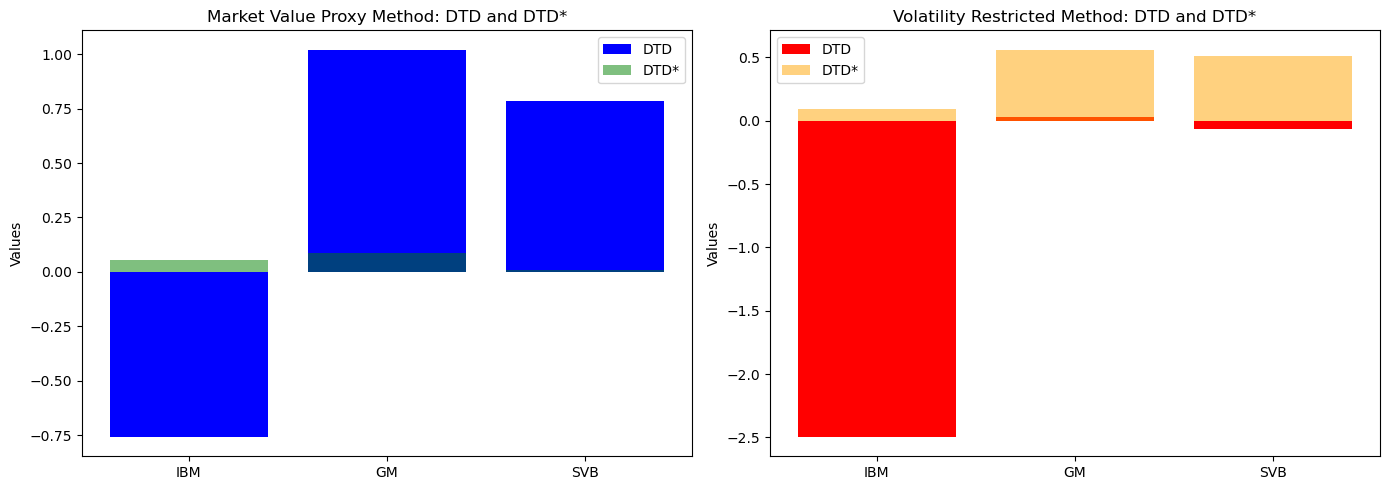

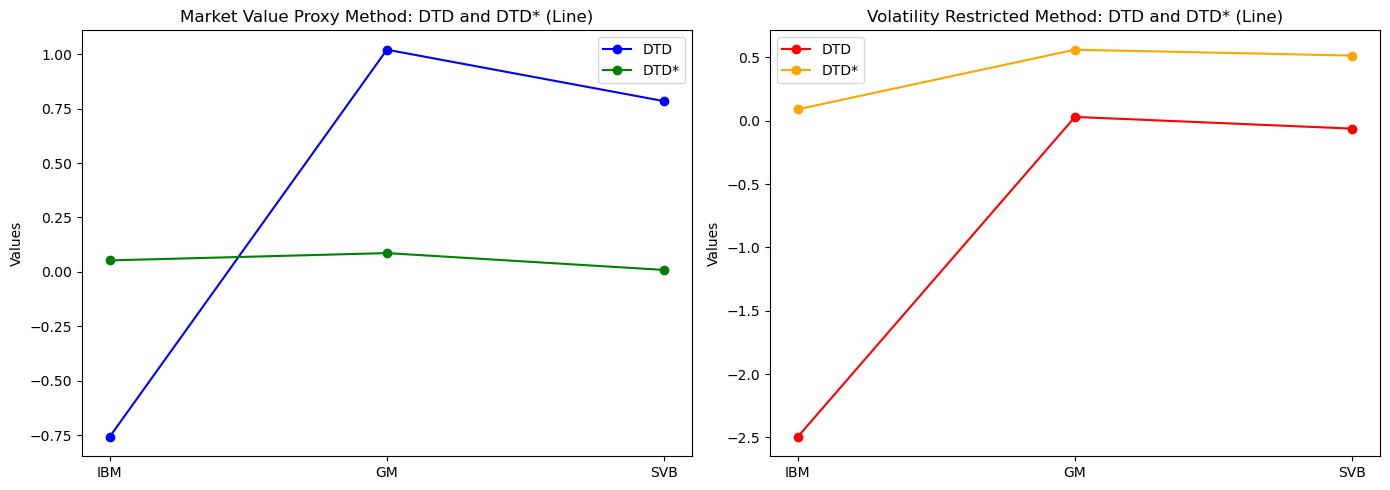

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your tables
companies = ['IBM', 'GM', 'SVB']

# Market Value Proxy Method Data
dtd_proxy = [-0.7582, 1.0210, 0.7845]
dtd_star_proxy = [0.0528, 0.0864, 0.0090]

# Volatility Restricted Method Data
dtd_vol_restricted = [-2.4957, 0.0300, -0.0624]
dtd_star_vol_restricted = [0.0900, 0.5606, 0.5139]

# Create a figure for bar charts
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Adjust for a single row with two plots

# Market Value Proxy Method Bar Chart
axs[0].bar(companies, dtd_proxy, color='blue', label='DTD')
axs[0].bar(companies, dtd_star_proxy, color='green', alpha=0.5, label='DTD*')
axs[0].set_title('Market Value Proxy Method: DTD and DTD*')
axs[0].set_ylabel('Values')
axs[0].legend()

# Volatility Restricted Method Bar Chart
axs[1].bar(companies, dtd_vol_restricted, color='red', label='DTD')
axs[1].bar(companies, dtd_star_vol_restricted, color='orange', alpha=0.5, label='DTD*')
axs[1].set_title('Volatility Restricted Method: DTD and DTD*')
axs[1].set_ylabel('Values')
axs[1].legend()

plt.tight_layout()
plt.show()

# Create a figure for line graphs
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Again, adjust for a single row with two plots

# Market Value Proxy Method Line Graph
axs[0].plot(companies, dtd_proxy, marker='o', color='blue', label='DTD')
axs[0].plot(companies, dtd_star_proxy, marker='o', color='green', label='DTD*')
axs[0].set_title('Market Value Proxy Method: DTD and DTD* (Line)')
axs[0].set_ylabel('Values')
axs[0].legend()

# Volatility Restricted Method Line Graph
axs[1].plot(companies, dtd_vol_restricted, marker='o', color='red', label='DTD')
axs[1].plot(companies, dtd_star_vol_restricted, marker='o', color='orange', label='DTD*')
axs[1].set_title('Volatility Restricted Method: DTD and DTD* (Line)')
axs[1].set_ylabel('Values')
axs[1].legend()

plt.tight_layout()
plt.show()